Thinkful Capstone Project #4 - **"Analyses of Crimes in Chicago, 2003-2018"**

by Ilango Gopalan, January 2020

## Introduction

Chicago has frequently made the news for its high murder rate and gun violence, including being admonished by the Trump Administration in 2017.  However, overall crime and homicides decreased year over year, making the city safer today despite what various news sources report. 

This project utilizes supervised and unsupervised learning techniques to analyze reported crimes across Chicago (specifically crimes that are classified as either **Violent**, or **Property** related), from 2003 through 2018.  Further exploration continues for crimes reported in 2018.  The readers of this report will be able to understand the following upon completion:

### 1. Is Chicago safer today?
### 2. What factors contribute to a crime being violent or property related?  
### 3. Where/When Violent or Property crimes may occur?  


# This version focuses on "Violent Crimes" and "Property Crimes" as designated by Federal Bureau of Investigation's (FBI) National Incident-Based Reporting System (NIBRS). Uniform Crime Reporting (UCR) Program.

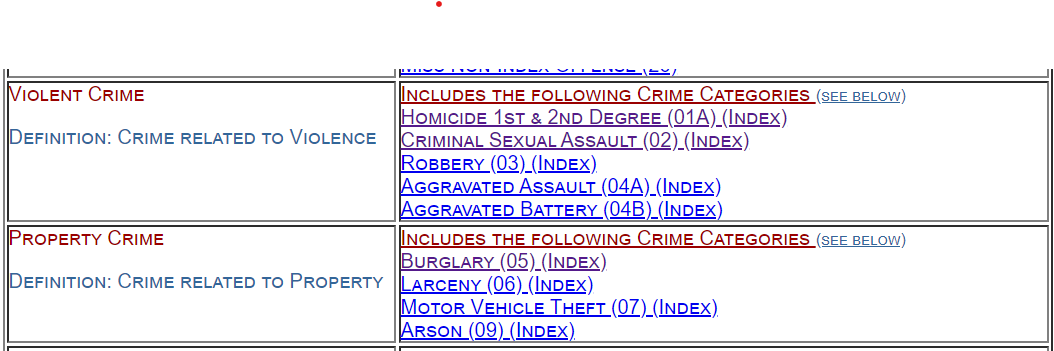

## Dataset

I acquired this dataset from Chicago Data Portal: 

**https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g**

There are 22 features (mostly of a categorical nature) with 5.7 million records, each one representing a single reported crime from 2003 through 2018.  

### Brief Description of some of the variables:

* ID / Case Number - unique identifiers of the reported instance of crime

* Date / Year - two different date features representing when the incident occurred (best estimate)

* Block - Address with just the first 3 digits (rest redacted), and a direction along with street; Chicago operates on a grid system, therefore all streets have one of the following - N, S, E, W

* IUCR / FBI Code - Illinois Uniform Crime Reporting Codes and FBI Codes for categories of crime

* Primary Type / Description - categorical values of the incident.Example: **Homicide** to Primary Type, and **Handgun** to Description

* Location Description - Residence, Apartment, Street...

* Arrest - Binary of Yes/No

* Beat / District - Police Beat and one of the 25 Districts within Chicago

* Ward / Community Area - Chicago has 50 Wards and 77 Community Areas

* X / Y Coordinates / Latitude / Longitude - All Location variables


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import datetime
import time
import pyarrow
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
crimes = pd.read_csv(('Crimes_-_2001_to_present.csv.xz'))

C:\Users\ilang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crimes

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,4.0,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,2222,22.0,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,835,8.0,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,313,3.0,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,122,1.0,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,731,7.0,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,813,8.0,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,1033,10.0,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,1432,14.0,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,123,1.0,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


## Data Cleaning

The dataset does not have complete information for years **2001, 2002, and 2019**, and I will remove records from those periods.  
Other features cannot be converted until the **NaN and Null** values have been removed.  As shown below, there are only 2 features with NaN values comprising over 1% of the entire dataset - **Ward** and **Community Area**.  Since Ward and Community Area NaN values are still less than 10% of the entire dataset, AND are **categorical values**,  I am choosing to drop those records.

### Features that will be converted OR dropped:

1. ID / Case Number / IUCR / Beat / FBI Code /Block / Domestic / X Coordinate / Y Coordinate / Updated On / Location - **DROPPED**
2. Date - from string to **datetime**
3. District / Ward / Community Area - from float to **integer**


## Feature Conversion

In [4]:
crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,4.0,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,2222,22.0,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,835,8.0,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,313,3.0,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,122,1.0,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [5]:
crimes.isnull().sum()*100/crimes.isnull().count()

ID                      0.000000
Case Number             0.000057
Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.085175
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000668
Ward                    8.742620
Community Area          8.723651
FBI Code                0.000000
X Coordinate            0.955925
Y Coordinate            0.955925
Year                    0.000000
Updated On              0.000000
Latitude                0.955925
Longitude               0.955925
Location                0.955925
dtype: float64

In [6]:
crimes = crimes[crimes.Year != 2001]
crimes = crimes[crimes.Year != 2002]
crimes = crimes[crimes.Year != 2019]

In [7]:
crimes.Year.unique()

array([2017, 2013, 2015, 2012, 2014, 2006, 2011, 2007, 2010, 2008, 2016,
       2003, 2018, 2009, 2005, 2004], dtype=int64)

In [8]:
crimes = crimes.dropna()

In [9]:
crimes.isnull().sum() #There are zero null or NaN values, and now specific features can be modified

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64

### District / Ward / Community Area - from float to integer

In [10]:
crimes.District = crimes.District.astype(int)
crimes.Ward = crimes.Ward.astype(int)
crimes['Community Area'] = crimes['Community Area'].astype(int)

# Crime Classification 

## 1. Violent or Property

## 2. Handgun or No Gun

## 3. Homicide or No Homicide

## 4. Arrest or No Arrest


In [11]:
#Create a feature that describes if a crime was Violent or Property related, based on the Primary Type Descriptions



def viol_prop(x):
    
    if x == 'HOMICIDE' or x == 'CRIM SEXUAL ASSAULT' or x == 'ROBBERY' or x == 'ASSAULT' or x == 'BATTERY':
        return "Violent"
    elif x == 'BURGLARY' or x== 'THEFT' or x == 'MOTOR VEHICLE THEFT' or x == 'ARSON':
        return "Property"
    else:
        return "Other"
    
    
crimes['Is_Violent_or_Is_Property'] = crimes['Primary Type'].apply(viol_prop)

## Drop the Other Crimes as they are not relevant for this model.  

In [12]:
crimes = crimes[crimes.Is_Violent_or_Is_Property != 'Other']

crimes.Is_Violent_or_Is_Property.value_counts()

Property    1824868
Violent     1655046
Name: Is_Violent_or_Is_Property, dtype: int64

### Date Modification

Currently, 'Date' is a string.  

1. I will convert to timestamp
2. I am then created 3 new featuresr
    a. The specific hour of the incident
    b. The specific day of the week of the incident
    c. The specific day of the month of the incident
    
Note: I chose to modify dates **after** separating out crimes as "Property" and "Violent"




In [13]:
crimes['Date'] = pd.to_datetime(crimes['Date'])

In [14]:
crimes['Crime_hour'] = crimes['Date'].apply(lambda x: x.hour)
crimes['Crime_day_of_week'] = crimes['Date'].apply(lambda x: x.dayofweek)
crimes['Crime_day_of_month'] = crimes['Date'].apply(lambda x: x.day)

In [15]:
crimes.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Is_Violent_or_Is_Property,Crime_hour,Crime_day_of_week,Crime_day_of_month
64183,10538294,HZ282529,2016-05-27 17:24:00,005XX W TAYLOR ST,0320,ROBBERY,STRONGARM - NO WEAPON,STREET,False,False,124,1,25,28,03,1173160.0,1895891.0,2016,06/03/2019 04:14:23 PM,41.869752,-87.639747,"(41.869752476, -87.639747289)",Violent,17,4,27


In [16]:
crimes.Crime_day_of_week.value_counts()

4    519362
5    501721
2    496503
0    493710
1    492344
3    491535
6    484739
Name: Crime_day_of_week, dtype: int64

In [17]:
# dummy_gun = pd.get_dummies(crimes.Gun_Involved)
# dummy_homicide = pd.get_dummies(crimes.Homicide)
dummy_violent = pd.get_dummies(crimes.Is_Violent_or_Is_Property)
dummy_arrest = pd.get_dummies(crimes.Arrest)

In [18]:
crimes = pd.concat([crimes, dummy_violent], axis=1)
crimes = pd.concat([crimes, dummy_arrest], axis=1)

In [19]:
crimes['Gun_Involved'] = crimes['Description'].apply(lambda x: 1 if 'HANDGUN' in x  else 0)
crimes['Homicide'] = crimes['Primary Type'].apply(lambda x: 1 if 'HOMICIDE' in x  else 0)
#crimes['Is_Violent_or_Is_Property'] = crimes['Primary Type'].apply(lambda x: 1 if 'Violent' in x  else 0)

In [20]:
crimes.columns

Index([                       'ID',               'Case Number',
                            'Date',                     'Block',
                            'IUCR',              'Primary Type',
                     'Description',      'Location Description',
                          'Arrest',                  'Domestic',
                            'Beat',                  'District',
                            'Ward',            'Community Area',
                        'FBI Code',              'X Coordinate',
                    'Y Coordinate',                      'Year',
                      'Updated On',                  'Latitude',
                       'Longitude',                  'Location',
       'Is_Violent_or_Is_Property',                'Crime_hour',
               'Crime_day_of_week',        'Crime_day_of_month',
                        'Property',                   'Violent',
                             False,                        True,
                    'Gun_

In [21]:
crimes_final = crimes[['Primary Type', 'Description','Arrest', 'Beat', 'District', 'Ward', 'Community Area',
                      'Is_Violent_or_Is_Property', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month', 'Property',
                       'Violent', False, True, 'Gun_Involved', 'Homicide', 'Year']]

In [22]:
crimes_final.head(1)

,Primary Type,Description,Arrest,Beat,District,Ward,Community Area,Is_Violent_or_Is_Property,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year
64183,ROBBERY,STRONGARM - NO WEAPON,False,124,1,25,28,Violent,17,4,27,0,1,1,0,0,0,2016


In [23]:
crimes_final.Is_Violent_or_Is_Property.value_counts()/len(crimes)  

Property    0.5244
Violent     0.4756
Name: Is_Violent_or_Is_Property, dtype: float64

In [24]:
crimes_final.Gun_Involved.value_counts()/len(crimes)

0    0.954697
1    0.045303
Name: Gun_Involved, dtype: float64

In [25]:
crimes_final.Homicide.value_counts()/len(crimes)

0    0.997651
1    0.002349
Name: Homicide, dtype: float64

In [26]:
crimes_final.Arrest.value_counts()/len(crimes)

False    0.846549
True     0.153451
Name: Arrest, dtype: float64

# Data Exploration

In [27]:
crimes_final.corr()

,Arrest,Beat,District,Ward,Community Area,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year
Arrest,1.000000,-0.000192,-0.000503,0.006564,-0.001774,0.005027,0.007005,0.000873,-0.154813,0.154813,-1.000000,1.000000,-0.018093,0.041027,-0.022708
Beat,-0.000192,1.000000,0.944768,0.636060,-0.506938,-0.001573,0.015403,-0.001621,0.077161,-0.077161,0.000192,-0.000192,-0.039343,-0.010385,-0.032871
District,-0.000503,0.944768,1.000000,0.684916,-0.501254,-0.001770,0.017183,-0.001604,0.071670,-0.071670,0.000503,-0.000503,-0.036225,-0.008970,-0.000522
Ward,0.006564,0.636060,0.684916,1.000000,-0.538204,0.003582,0.016700,-0.000681,0.092240,-0.092240,-0.006564,0.006564,-0.046126,-0.010366,0.020634
Community Area,-0.001774,-0.506938,-0.501254,-0.538204,1.000000,-0.001003,-0.017286,0.000089,-0.101871,0.101871,0.001774,-0.001774,0.050082,0.012807,-0.021750
Crime_hour,0.005027,-0.001573,-0.001770,0.003582,-0.001003,1.000000,-0.042658,0.012385,-0.009286,0.009286,-0.005027,0.005027,0.004021,-0.008477,0.006383
Crime_day_of_week,0.007005,0.015403,0.017183,0.016700,-0.017286,-0.042658,1.000000,-0.001940,-0.038682,0.038682,-0.007005,0.007005,0.008208,0.005514,0.007399
Crime_day_of_month,0.000873,-0.001621,-0.001604,-0.000681,0.000089,0.012385,-0.001940,1.000000,0.001334,-0.001334,-0.000873,0.000873,0.004530,0.000549,0.001583
Property,-0.154813,0.077161,0.071670,0.092240,-0.101871,-0.009286,-0.038682,0.001334,1.000000,-1.000000,0.154813,-0.154813,-0.228739,-0.050948,0.005798
Violent,0.154813,-0.077161,-0.071670,-0.092240,0.101871,0.009286,0.038682,-0.001334,-1.000000,1.000000,-0.154813,0.154813,0.228739,0.050948,-0.005798


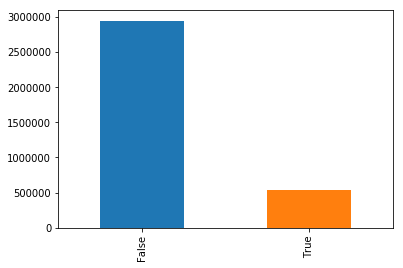

In [28]:
crimes_final.Arrest.value_counts().plot.bar()  #Total arrests vs. no arrests.  
#This could explain why people feel that Chicago is crime-ridden especially if crimes appear unsolved

Text(0, 0.5, 'Total Crimes')

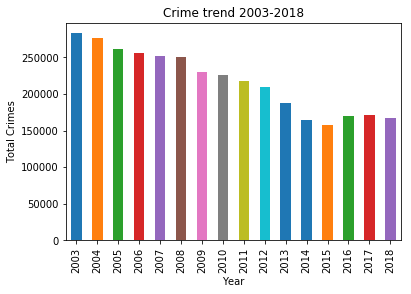

In [29]:
crimes_final.Year.value_counts(sort=False).plot.bar(title = 'Crime trend 2003-2018')
plt.xlabel('Year')
plt.ylabel('Total Crimes')

In [30]:
crimes_handguns = crimes_final.Description.str.contains('HANDGUN')

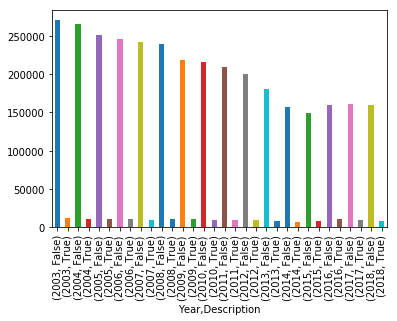

In [31]:
crimes_final.groupby(['Year', crimes_handguns]).size().plot.bar()
# crimes.groupby(['Year', crimes_handguns]).plot.bar()

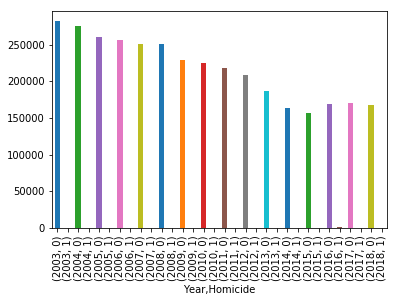

In [32]:
crimes_final.groupby(['Year', 'Homicide']).size().plot.bar()

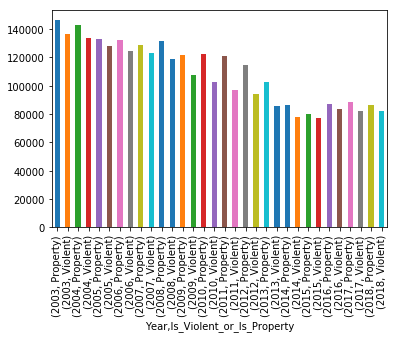

In [33]:
crimes_final.groupby(['Year','Is_Violent_or_Is_Property']).size().plot.bar()

# Modeling - With supervised and unsupervised learning

## Note: Due to extremely high computation cost on 3.5 million records, modeling will focus on records for 'Year' 2018.   In the future to push to production, I will use my trained models on all years. 


In [34]:
crimes_2018 = crimes_final['Year']==2018

In [35]:
crimes_2018_final = crimes_final[crimes_2018]

In [36]:
crimes_2018_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167902 entries, 64197 to 2220355
Data columns (total 18 columns):
Primary Type                 167902 non-null object
Description                  167902 non-null object
Arrest                       167902 non-null bool
Beat                         167902 non-null int64
District                     167902 non-null int32
Ward                         167902 non-null int32
Community Area               167902 non-null int32
Is_Violent_or_Is_Property    167902 non-null object
Crime_hour                   167902 non-null int64
Crime_day_of_week            167902 non-null int64
Crime_day_of_month           167902 non-null int64
Property                     167902 non-null uint8
Violent                      167902 non-null uint8
False                        167902 non-null uint8
True                         167902 non-null uint8
Gun_Involved                 167902 non-null int64
Homicide                     167902 non-null int64
Year           

There are ~ 168,000 reported crimes in 2018 (167,902), which still offers an adequate amount of data for analysis

In [37]:
crimes_2018_final.Property.value_counts()

1    86024
0    81878
Name: Property, dtype: int64

In [38]:
crimes_2018_final.columns

Index([             'Primary Type',               'Description',
                          'Arrest',                      'Beat',
                        'District',                      'Ward',
                  'Community Area', 'Is_Violent_or_Is_Property',
                      'Crime_hour',         'Crime_day_of_week',
              'Crime_day_of_month',                  'Property',
                         'Violent',                       False,
                              True,              'Gun_Involved',
                        'Homicide',                      'Year'],
      dtype='object')

## Decision Tree - What factors contribute to a crime being violent or property related?


In [39]:
crimes_2018_final.Property.value_counts()
#crimes.Violent.value_counts()

1    86024
0    81878
Name: Property, dtype: int64

In [40]:
crimes_2018_final.head(1)

,Primary Type,Description,Arrest,Beat,District,Ward,Community Area,Is_Violent_or_Is_Property,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year
64197,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,False,1231,12,27,28,Violent,5,5,23,0,1,1,0,0,0,2018


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz


In [42]:

X = crimes_2018_final[['Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month']]
y = crimes_2018_final.Violent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 9,
    max_depth = 2,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

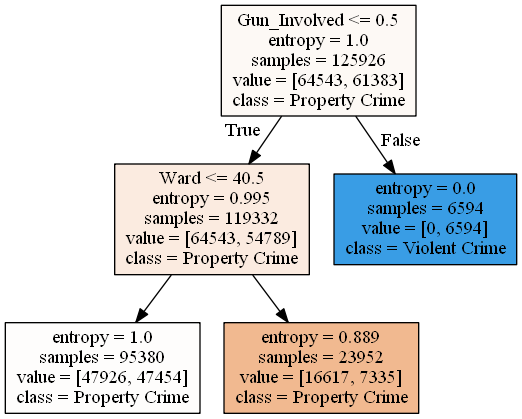

In [43]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Property Crime', 'Violent Crime'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [44]:
crimes_2018_final.shape



(167902, 18)

In [45]:
y_train.value_counts()

0    64543
1    61383
Name: Violent, dtype: int64

In [46]:
X_train.Gun_Involved.value_counts()

0    119332
1      6594
Name: Gun_Involved, dtype: int64

In [47]:
predictions = dt.predict(X_test)

In [48]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

Accuracy score: 0.5623451496093006
Precision score: 1.0
Recall score: 0.10363503293486216


In [49]:
#Based on time and location, can we predict if a crime is violent or property based?
X = crimes_2018_final[['Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month']]
y = crimes_2018_final.Violent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 4,
    max_depth = 3,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

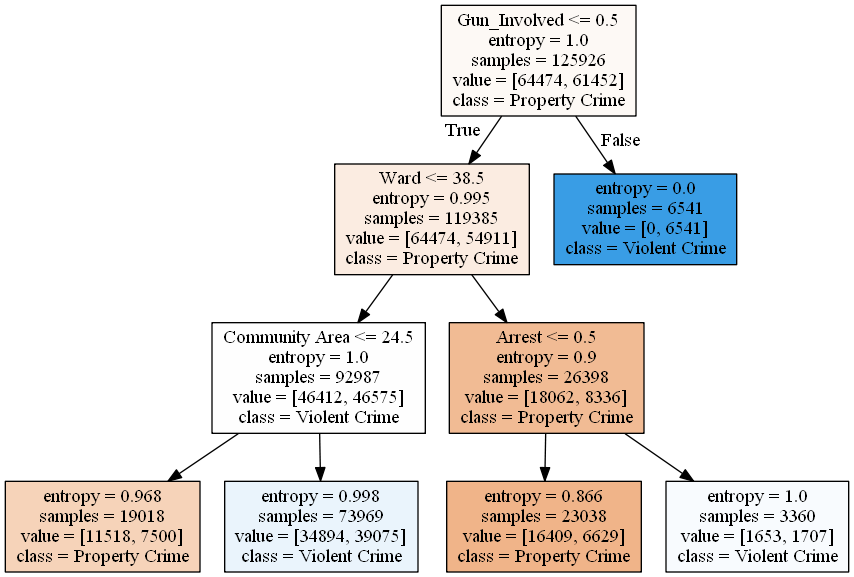

In [50]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Property Crime', 'Violent Crime'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [51]:
predictions = dt.predict(X_test)

In [52]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

Accuracy score: 0.5956022489041357
Precision score: 0.561794936074204
Recall score: 0.7679917751884853


In [53]:
confusion_matrix(y_test, predictions)

array([[ 9314, 12236],
       [ 4739, 15687]], dtype=int64)

## Random Forest - What factors contribute to a crime being violent or property related?


In [54]:
X_train.head(1)

,Ward,Community Area,Year,Arrest,Gun_Involved,Homicide,Crime_hour,Crime_day_of_week,Crime_day_of_month
1076730,25,31,2018,True,0,0,21,3,31


In [56]:
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion= 'entropy',min_samples_split = 10, min_samples_leaf = 2,     
                                     max_features = 9)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
cross_val_score(rfc, X, y, cv = 5)

array([0.62717013, 0.62178017, 0.61892141, 0.62248362, 0.62449745])

In [58]:
predictions = rfc.predict(X_test)

In [59]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

Accuracy score: 0.634576901086335
Precision score: 0.6308586716057004
Recall score: 0.6003133261529423


In [60]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rfc.feature_importances_}).\
sort_values('importance', ascending = False)

In [61]:
fi

,feature,importance
8,Crime_day_of_month,0.285429
6,Crime_hour,0.201174
1,Community Area,0.132384
7,Crime_day_of_week,0.123137
0,Ward,0.121955
4,Gun_Involved,0.103006
3,Arrest,0.028044
5,Homicide,0.004871
2,Year,0.000000


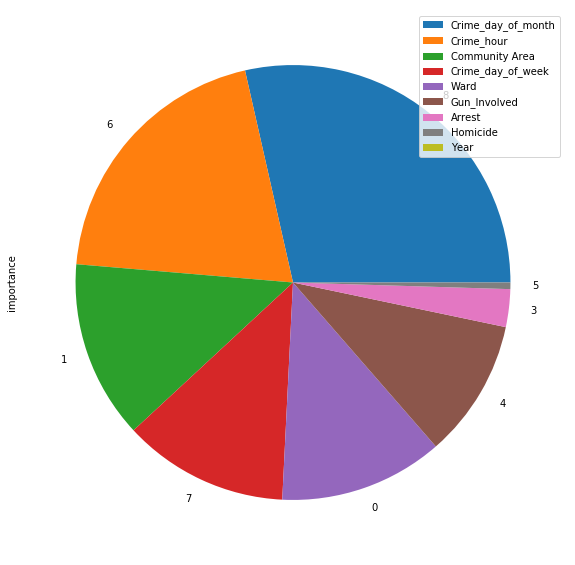

In [62]:
fi.plot.pie(y='importance', figsize = (10,10))
plt.legend(fi.feature)

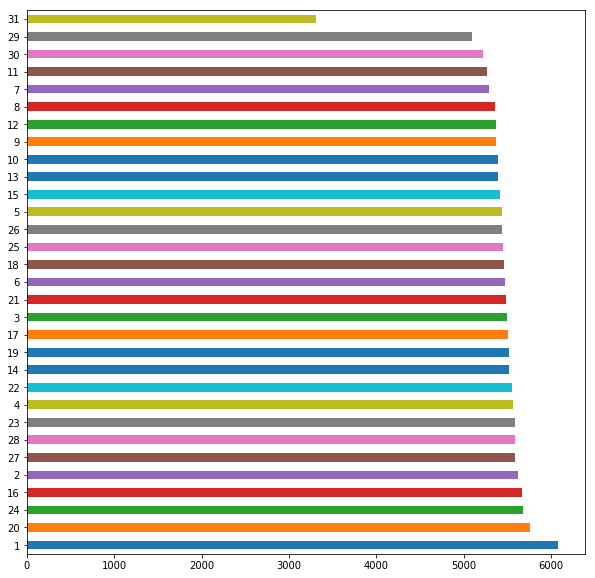

In [63]:
crimes_2018_final.Crime_day_of_month.value_counts().plot.barh(figsize=(10,10))

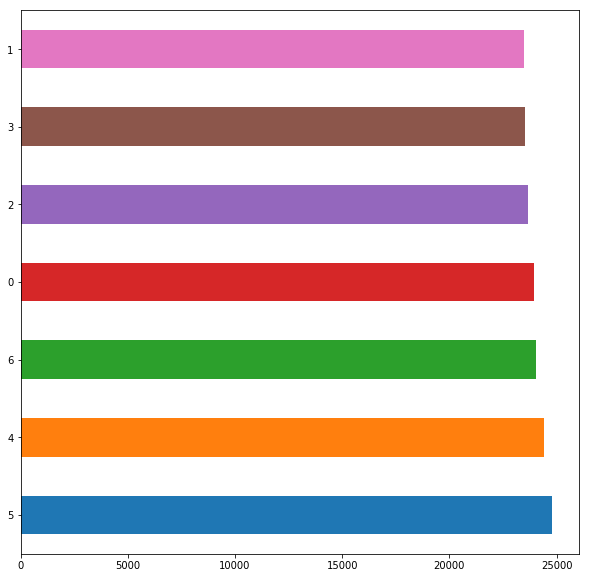

In [64]:
crimes_2018_final.Crime_day_of_week.value_counts().plot.barh(figsize=(10,10))

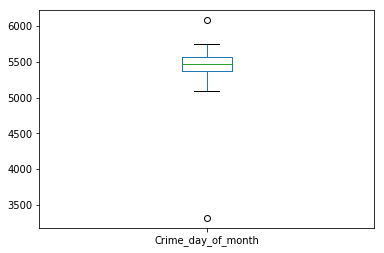

In [65]:
crimes_2018_final.Crime_day_of_month.value_counts().plot.box()

## Clustering- Where Violent or Property crimes may occur?

In [66]:
scaler = MinMaxScaler()

scaler.fit(crimes_2018_final[['Ward']])
crimes_2018_final['Ward'] = scaler.transform(crimes_2018_final[['Ward']])

scaler.fit(crimes_2018_final[['Community Area']])
crimes_2018_final['Community Area'] = scaler.transform(crimes_2018_final[['Community Area']])

scaler.fit(crimes_2018_final[['Year']])
crimes_2018_final['Year'] = scaler.transform(crimes_2018_final[['Year']])

scaler.fit(crimes_2018_final[['Crime_hour']])
crimes_2018_final['Crime_hour'] = scaler.transform(crimes_2018_final[['Crime_hour']])

scaler.fit(crimes_2018_final[['Crime_day_of_week']])
crimes_2018_final['Crime_day_of_week'] = scaler.transform(crimes_2018_final[['Crime_day_of_week']])

scaler.fit(crimes_2018_final[['Crime_day_of_month']])
crimes_2018_final['Crime_day_of_month'] = scaler.transform(crimes_2018_final[['Crime_day_of_month']])

scaler.fit(crimes_2018_final[['District']])
crimes_2018_final['District'] = scaler.transform(crimes_2018_final[['District']])

scaler.fit(crimes_2018_final[['Beat']])
crimes_2018_final['Beat'] = scaler.transform(crimes_2018_final[['Beat']])



C:\Users\ilang\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\ilang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ilang\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\ilang\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [67]:


X = crimes_2018_final[['District','Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month', 'Violent']]

In [68]:
#PCA for visualization - KMeans

X_pca = PCA(2).fit_transform(X)
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

In [69]:
n_clusters =5
km = KMeans(n_clusters) 

y_pred = km.fit_predict(X_pca)

from sklearn import metrics
print(metrics.silhouette_score(X_pca, y_pred, metric='euclidean'))

0.6423038624670301


In [70]:
crimes_2018_final['cluster'] = y_pred

C:\Users\ilang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
crimes_2018_final

,Primary Type,Description,Arrest,Beat,District,Ward,Community Area,Is_Violent_or_Is_Property,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year,cluster
64197,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,False,0.462046,0.366667,0.530612,0.355263,Violent,0.217391,0.833333,0.733333,0,1,1,0,0,0,0.0,3
64198,BATTERY,SIMPLE,False,0.004950,0.000000,0.061224,0.407895,Violent,1.000000,0.833333,0.733333,0,1,1,0,0,0,0.0,1
64199,ASSAULT,AGGRAVATED: HANDGUN,False,0.867162,0.700000,0.673469,0.947368,Violent,0.260870,0.333333,0.866667,0,1,1,0,1,0,0.0,3
64200,BATTERY,SIMPLE,False,0.293317,0.233333,0.448980,0.815789,Violent,0.652174,0.333333,0.100000,0,1,1,0,0,0,0.0,1
64201,ASSAULT,AGG PRO.EMP: HANDGUN,True,0.042079,0.033333,0.040816,0.447368,Violent,0.130435,0.333333,0.866667,0,1,0,1,1,0,0.0,1
64202,BATTERY,AGGRAVATED:KNIFE/CUTTING INSTR,False,0.297442,0.233333,0.326531,0.855263,Violent,0.695652,0.333333,0.100000,0,1,1,0,0,0,0.0,1
64205,ASSAULT,AGGRAVATED: HANDGUN,False,0.290429,0.233333,0.265306,0.736842,Violent,0.826087,1.000000,0.233333,0,1,1,0,1,0,0.0,1
64209,BATTERY,SIMPLE,False,0.709983,0.566667,0.020408,0.092105,Violent,0.304348,0.166667,0.033333,0,1,1,0,0,0,0.0,3
64210,ASSAULT,AGGRAVATED: HANDGUN,True,0.206683,0.166667,0.326531,0.921053,Violent,0.869565,0.333333,0.300000,0,1,0,1,1,0,0.0,1
64295,ASSAULT,AGGRAVATED PO: OTHER DANG WEAP,True,0.004125,0.000000,0.836735,0.355263,Violent,0.652174,0.666667,0.633333,0,1,0,1,0,0,0.0,3


In [72]:
cluster0 = crimes_2018_final[crimes_2018_final.cluster ==0]
cluster1 = crimes_2018_final[crimes_2018_final.cluster ==1]
cluster2 = crimes_2018_final[crimes_2018_final.cluster ==2]
cluster3 = crimes_2018_final[crimes_2018_final.cluster ==3]
cluster4 = crimes_2018_final[crimes_2018_final.cluster ==4]

In [73]:
print(cluster0.Violent.value_counts())
print(cluster1.Violent.value_counts())
print(cluster2.Violent.value_counts())
print(cluster3.Violent.value_counts())
print(cluster4.Violent.value_counts())

0    26036
Name: Violent, dtype: int64
1    44130
Name: Violent, dtype: int64
0    36043
Name: Violent, dtype: int64
1    37748
Name: Violent, dtype: int64
0    23945
Name: Violent, dtype: int64


## Cluster Analysis
From an initial look at the clusters, cluster1 and cluster 3 comprise all 'Violent' crimes

In [74]:
print(cluster0.Homicide.value_counts())
print(cluster1.Homicide.value_counts())
print(cluster2.Homicide.value_counts())
print(cluster3.Homicide.value_counts())
print(cluster4.Homicide.value_counts())

0    26036
Name: Homicide, dtype: int64
0    43776
1      354
Name: Homicide, dtype: int64
0    36043
Name: Homicide, dtype: int64
0    37511
1      237
Name: Homicide, dtype: int64
0    23945
Name: Homicide, dtype: int64


In [75]:
crimes_2018_final.Homicide.value_counts()

0    167311
1       591
Name: Homicide, dtype: int64

In [76]:
crimes_2018_final.groupby("cluster").mean()

,Arrest,Beat,District,Ward,Community Area,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year
cluster,,,,,,,,,,,,,,,
0,0.090528,0.770651,0.618414,0.803735,0.119322,0.583079,0.514217,0.493860,1.0,0.0,0.909472,0.090528,0.000000,0.000000,0.0
1,0.180354,0.229182,0.181206,0.225319,0.683062,0.563021,0.503331,0.490161,0.0,1.0,0.819646,0.180354,0.110673,0.008022,0.0
2,0.084510,0.240125,0.190057,0.190767,0.648066,0.570348,0.474073,0.491614,1.0,0.0,0.915490,0.084510,0.000000,0.000000,0.0
3,0.179665,0.618003,0.495428,0.667153,0.276225,0.555497,0.532902,0.489894,0.0,1.0,0.820335,0.179665,0.101568,0.006278,0.0
4,0.086615,0.412900,0.329988,0.614411,0.423409,0.583820,0.491251,0.496053,1.0,0.0,0.913385,0.086615,0.000000,0.000000,0.0


In [77]:
crimes_2018_final.groupby("cluster").mean().corr()

,Arrest,Beat,District,Ward,Community Area,Crime_hour,Crime_day_of_week,Crime_day_of_month,Property,Violent,False,True,Gun_Involved,Homicide,Year
Arrest,1.000000,-0.086104,-0.086153,-0.149784,0.157906,-0.860630,0.635779,-0.789172,-0.999087,0.999087,-1.000000,1.000000,0.997823,0.987683,NaN
Beat,-0.086104,1.000000,0.999999,0.942736,-0.993037,0.228568,0.710226,0.230736,0.117664,-0.117664,0.086104,-0.086104,-0.149525,-0.206317,NaN
District,-0.086153,0.999999,1.000000,0.943045,-0.993135,0.228680,0.710273,0.231195,0.117699,-0.117699,0.086153,-0.086153,-0.149583,-0.206417,NaN
Ward,-0.149784,0.942736,0.943045,1.000000,-0.970448,0.361008,0.645909,0.450761,0.178842,-0.178842,0.149784,-0.149784,-0.209883,-0.264708,NaN
Community Area,0.157906,-0.993037,-0.993135,-0.970448,1.000000,-0.302845,-0.661755,-0.329692,-0.188190,0.188190,-0.157906,0.157906,0.220942,0.278794,NaN
Crime_hour,-0.860630,0.228568,0.228680,0.361008,-0.302845,1.000000,-0.417795,0.939107,0.875948,-0.875948,0.860630,-0.860630,-0.862740,-0.831933,NaN
Crime_day_of_week,0.635779,0.710226,0.710273,0.645909,-0.661755,-0.417795,1.000000,-0.340017,-0.611609,0.611609,-0.635779,0.635779,0.584785,0.531388,NaN
Crime_day_of_month,-0.789172,0.230736,0.231195,0.450761,-0.329692,0.939107,-0.340017,1.000000,0.799018,-0.799018,0.789172,-0.789172,-0.795797,-0.783684,NaN
Property,-0.999087,0.117664,0.117699,0.178842,-0.188190,0.875948,-0.611609,0.799018,1.000000,-1.000000,0.999087,-0.999087,-0.998470,-0.987841,NaN
Violent,0.999087,-0.117664,-0.117699,-0.178842,0.188190,-0.875948,0.611609,-0.799018,-1.000000,1.000000,-0.999087,0.999087,0.998470,0.987841,NaN


# Conclusion

1. Is Chicago safer today?
2. What factors contribute to a crime being violent or property related?¶
3. Where/When Violent or Property crimes may occur?


Overall crime, as categorized either 'Violent' or 'Property' related, has steadily declined year over year.  

The homicide rate also decreased as well.  

Crimes involving a gun resulted in incidents categorized as 'Violent', though not all violent crimes included a weapon.

Violent crimes were more related to the **day** (weekend), where as Property crimes were associated to the **hour**.  

